# Make final classifier using mutant concentration
**Goal**: Identify patients that don't respond.
These patients we don't have to treat.

Perform the following steps:

1) Combine data with CNV.

2) Compare harmonic versus delta.

3) Compare clinical data versus clinical and genomic data.

4) Select best classification model based on AUC.

5) For this best model, compare number of molecules.

6) Perform cross validation.

7) Make plots for parameter importance.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from pipelines import benchmark_pipelines, build_classifier_pipelines, pipeline_Freeman
from views import view_linear_model_freeman

# 1) Combine data

In [2]:
from source import read_preprocessed_data
from transform import combine_tsv_files

In [3]:
# Harmonic mean genomic variable.
X_train_hm, y_train_hm = combine_tsv_files(
    "output/train__harmonic_mean__No. Mutant Molecules per mL.tsv",
    "output/train__harmonic_mean__CNV Score.tsv",
)
# Difference genomic variable.
X_train_diff, y_train_diff = combine_tsv_files(
    "output/train__difference__No. Mutant Molecules per mL.tsv",
    "output/train__difference__CNV Score.tsv",
)

# 2) Select best model

In [4]:
y_train_resp = y_train_hm["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']
pos_label = 'responder (pr+cr)'
y_train_resp = y_train_resp == pos_label

In [5]:
ps_class = build_classifier_pipelines()

In [6]:
b_difference = benchmark_pipelines(
    ps_class, X_train_diff, y_train_resp, metric='roc_auc',
)

In [7]:
b_harmonic_mean = benchmark_pipelines(
    ps_class, X_train_hm, y_train_resp, metric='roc_auc',
)

In [8]:
b_harmonic_mean
# print(b.round(2).to_latex())

,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std
DecisionTreeClassifier,0.552806,0.104126,0.590476,0.095786,0.575085,0.056811
RandomForestClassifier,0.615136,0.139969,0.703146,0.085631,0.594558,0.106662
GaussianNB,0.552041,0.114205,0.649150,0.100567,0.646429,0.117586
GradientBoostingClassifier,0.605187,0.050892,0.638010,0.064842,0.622789,0.084546
KNeighborsClassifier,0.610119,0.068823,0.519388,0.072646,0.633929,0.078792
LogisticRegression,0.607823,0.079752,0.556293,0.117064,0.616156,0.049756
SVC,0.658673,0.100210,0.528741,0.020915,0.649660,0.079216
DummyClassifier,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000


In [9]:
print('On average harmonic mean is better by', (b_harmonic_mean.mean(axis=1) - b_difference.mean(axis=1)).mean(), 'ROC AUC')
b_difference

On average harmonic mean is better by -0.0024624022996698816 ROC AUC


,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std
DecisionTreeClassifier,0.552806,0.104126,0.678231,0.026399,0.623724,0.057201
RandomForestClassifier,0.615136,0.139969,0.632993,0.073664,0.606293,0.087505
GaussianNB,0.552041,0.114205,0.614286,0.142071,0.594643,0.097214
GradientBoostingClassifier,0.605187,0.050892,0.563435,0.128879,0.534779,0.064154
KNeighborsClassifier,0.610119,0.068823,0.573980,0.066187,0.645578,0.134522
LogisticRegression,0.607823,0.079752,0.600510,0.122028,0.594218,0.098226
SVC,0.658673,0.100210,0.522789,0.130524,0.644813,0.113977
DummyClassifier,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000


The prediction with difference instead of harmonic mean is therefore marginally worse.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


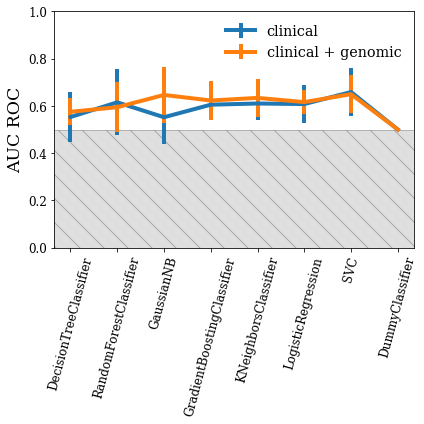

In [10]:
b = b_harmonic_mean
plt.rc('font', family='serif')
import matplotlib
context = {
#     'font.size': 22,
    'lines.linewidth': 4,
    'figure.autolayout': True,
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'xx-large',
    'axes.titlesize': 'xx-large',
}
# fig = plt.figure(figsize=(4, 3))
with plt.rc_context(context):
    fig = plt.figure(figsize=(6, 6))
    degrees=75
    plt.ylabel('AUC ROC')
    plt.xticks(rotation=degrees)
    plt.ylim([0, 1])
    plt.gca().fill_between([-1, 8], 0, 0.5, facecolor='grey', edgecolor='k', alpha=0.25, hatch='\\')
    plt.errorbar(b.index, b['Richard mean'], yerr=b['Richard std'], label='clinical')
    plt.errorbar(b.index, b['Freeman mean'], yerr=b['Freeman std'], label='clinical + genomic')
    plt.legend(frameon=False)
    plt.tight_layout()
plt.savefig('figs/comparison_classifiers.png', bbox_inches = 'tight')
plt.savefig('figs/comparison_classifiers.eps', bbox_inches = 'tight')

# 4) Choose model logistic regression.
The logistic regression model doesn't have the best accuracy in absolute terms, but is much simpler than the RandomForest. So by occams razor, we pick it.

In [11]:
random_state=1234
logistic_Freeman_parameters = {
    "random_state": random_state,
#     "penalty": "l2",
#     "class_weight": "balanced",
    "solver": "newton-cg",
#     "C": 1.0,
#     "max_iter": 10000,
#     'tol': 0.00001,
}
logistic_Freeman = pipeline_Freeman(LogisticRegression, **logistic_Freeman_parameters)

# 6) Cross validation
Find the optimal hyper parameters.

In [12]:
logistic_regression_hyper_parameters = {
#     "filter_rare_mutations__top_k_features": (4, 5, 6, 7, 8, 10, 12, 18, 24, 48),
    "estimator__C": [0.025, 0.05, 0.075, 0.1, 0.175, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0],
    "estimator__class_weight": ["balanced", None],
}
clf_search = GridSearchCV(
    logistic_Freeman,
    logistic_regression_hyper_parameters,
    scoring="roc_auc",
    n_jobs=8,
    cv=5,
)

In [13]:
# clf_search.fit(X_train_hm, y_train_resp)

In [14]:
# print("Best parameters set found on development set:")
# print()
# print(clf_search.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf_search.cv_results_['mean_test_score']
# stds = clf_search.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf_search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# print()

In [15]:
# # Non-convergent best parameters under elasticnet.
# best_params = {
#     'estimator__C': 2.0,
#     'estimator__class_weight': None,
#     'estimator__l1_ratio': 0.025,
#     "estimator__penalty": "l1",
#     "estimator__solver": "saga",
#     'filter_rare_mutations__top_k_features': 4,
#     'transform_columns__age_discretizer__n_bins': 2,
# }

# Best parameters under L2 norm.
best_params = {
    "estimator__C": 0.1,
    "estimator__class_weight": "balanced",
    "estimator__solver": "newton-cg",
#     "estimator__solver": "saga",
#     "filter_rare_mutations__top_k_features": 5,
#     "transform_columns__age_discretizer__n_bins": 2,
}

In [16]:
# assert best_params == clf_search.best_params_

In [17]:
# Pick the best parameteres.
logistic_Freeman.set_params(**best_params)
logistic_Freeman.fit(X_train_hm, y_train_resp)

Pipeline(memory=None,
         steps=[('clinical_curation',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clinical_data_curation at 0x7fda3f852ee0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('filter_clinical_variables',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function drop_specific_phenoty...
                                                   'adrenalmeta', 'livermeta',
                                                   'lungmeta', 'skeletonmeta',
                                                   'age'])],
                                   verbose=False)),
                ('estimator',
                 LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                                    fit_in

# 7) Make plots of the model

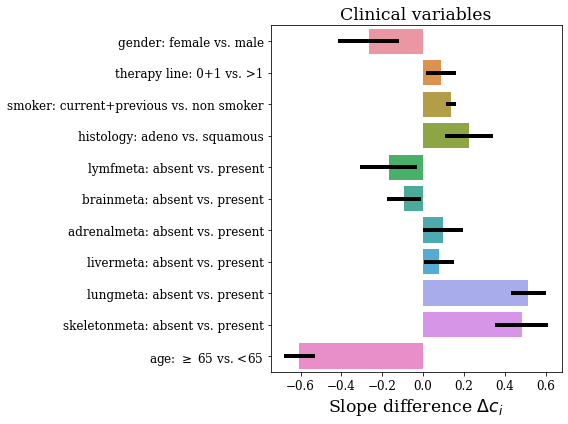

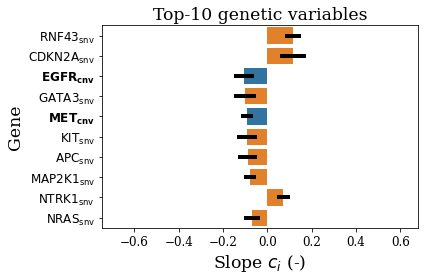

In [18]:
figure_filenames = ("logistic_regression_clinical_freeman", "logistic_regression_genetic_freeman")
view_linear_model_freeman(
    X_train_diff, 
    y_train_resp, 
    logistic_Freeman, 
    filenames=figure_filenames, 
    thresshold=0.1,
)